## Camera Models

### The Pin-hole Camera Model

The pin-hole camera model is a widely used camera model in computer vision. In this model, the light passes trough just the center C before it is projected onto an image plane. The image plane in an actual camera would be upside down behind the camera center but the model is the same.
With a pin-hole camera, a 3D point X is projected to an image point x (both expressed in homogeneous coordinates) as
$$λx = PX$$
-> P = 3 x 4 matrix called camera matrix  
-> X = {X,Y,Z,W} (3D point with 4 elements)  
-> λ = inverse depth of the 3D point and is needed if we want all coordinates to be homogeneous with the last value normalized to one   

### The camera matrix

The camera matrix can be divided as 

$$ P = K [R|t] $$

-> R is a rotation matrix describing the orientation of the camera  
-> t is a 3D translation vector describing the position of the camera center  
-> K is the calibration matrix describing the projection properties of the camera  
The calibration matrix depends only on the camera properties and is in a general form written as  

$$K = \begin{bmatrix}αf & s & c_{x}\\
0 & f & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$
 
-> f = focal length = distance between image plane and camera center   
-> s = the skew =  used if the pixel array of the sensor is skewed and therefore can be set to zero  
That results:  

$$K = \begin{bmatrix}αf & 0 & c_{x}\\
0 & f & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$

-> α = aspect ratio = s used for non-square pixel elements
(It is often safe to assume alpha = 1)  
That results in 

$$K = \begin{bmatrix}f & 0 & c_{x}\\
0 & f & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$

Besides the focal length, the only remaining parameters are the coordinates of the optical center (sometimes called the principal point ), the image point c = [cx, cy] where the optical axis intersects the image plane. 
Since this is usually in the center of the image and image coordinates are measured from the top left corner, these values are often well approximated with half the width and height of the image. It is worth noting that in this last case the only unknown variable is the focal length f.

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

class Camera(object):
    """ Class for representing pin-hole cameras. """
    def __init__(self,P):
        """ Initialize P = K[R|t] camera model. """
        self.P = P
        self.K = None # calibration matrix
        self.R = None # rotation
        self.t = None # translation
        self.c = None # camera center
    def project(self,X):
        """ Project points in X (4*n array) and normalize coordinates. """
        x = np.dot(self.P,X)
        for i in range(3):
            x[i] /= x[2]
        return x
    
    def factor(self):
        """ Factorize the camera matrix into K,R,t as P = K[R|t] """

        # factor first 3*3 part
        K, R = linalg.rq(self.P[:,:3])

        # make diagonal of K positive
        T = np.diag(np.sign(np.diag(K)))
        if linalg.det(T) < 0:
            T[1,1] *= -1

        self.K = np.dot(K,T)
        self.R = np.dot(T,R) # T is its own inverse
        self.t = np.dot(linalg.inv(self.K), self.P[:, 3])

        return self.K, self.R, self.t

    def center(self):
        """ Compute and return the camera center """

        if self.c is not None:
            return self.c

        else:
            # compute c by factoring
            self.factor()
            self.c = -np.dot(self.R.T, self.t)
            return self.c

def rotation_matrix(a):
    """ Creates a 3D rotation matrix for rotation around the axis of the vector a """

    R = np.eye(4)
    R[:3, :3] = linalg.expm([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
    return R

The camera class handles all operations we need for modeling cameras and projections. The helper function rotation_matrix() is used to create a rotation matrix for 3D rotations around a vector. The function factor() used a matrix factorization called RQ-factorization. Because of this the program is able to recover the internal parameters K and and the camara position and pose t and R, if a camera matrix P of the form in equaion is given. The center() function is needed because if a camera projection (P) is given, it is useful to know where the position of the camera is. This is what the funtion does.  

For a camera with **P** = **K**[**R**|**t**] this gives  

So the camera center can be computed as  

K[R|t]**C** = KR**C** + K**t** = 0   
   
**C** = -R<sup>T</sup> **t**


#### Projecting 3D points

The following example is data from the Oxford "Model House" dataset.

In [2]:
points = np.loadtxt('./Examples/Model_House/house.p3d')

points = points.T
points = np.vstack((points, np.ones(points.shape[1])))

# setup camera
P = np.hstack((np.eye(3), np.array([[0],[0],[-10]])))

cam = Camera(P)

In the following blog of code, the points will be projected into a view.

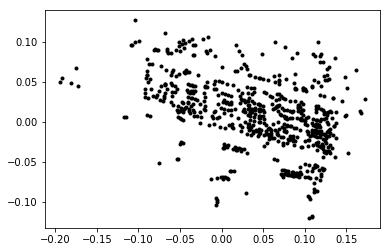

In [3]:
# project the points
x = cam.project(points)

#plot projection
plt.figure()
plt.plot(x[0], x[1], 'k.')
plt.show()

Trajectory of projected points under camera rotation. (Here is the rotation_matrix() function needed.)

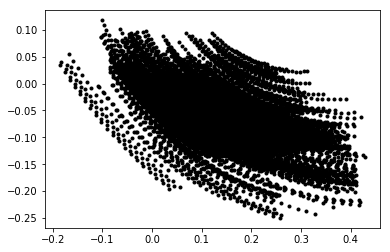

In [4]:
# create transformation
r = 0.05 * np.random.rand(3)
rot = rotation_matrix(r)

# rotate camera and project
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k.')

plt.show()

### Camera Calibration

Calibrating a camera means determining the internal camera parameters, in our case the matrix K.

#### A simple calibration method

- Measure the sides **(dX and dY)** of your rectangular calibration object.
- Place the camera and the calibration object on a flat surface so that the camera back and calibration object are parallel and the object is roughly in the center of the camera’s view. You might have to raise the camera or object to get a nice alignment.
- Measure the distance **(dZ)** from the camera to the calibration object.
- Take a picture and check that the setup is straight, meaning that the sides of the calibration object align with the rows and columns of the image.
- Measure the width **(dx)** and height **(dy)** of the object in pixels.

The following relation gives the focal length

$$ f_x = \frac{dx}{dX}\,dZ  ,      f_y = \frac{dy}{dY}\,dZ$$

In [5]:
def my_calibration(sz):
    row,col = sz
    fx = 2555*col/2592 #2592 is the camera resolution in width
    fy = 2586*row/1936 #1936 is the camera resolution in height
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    print(K)
    return K

In this example setup, the object was measured to be by 130 (dX) by 185mm (dY) 2592 is the camera resolution in width and 1936 is the camera resolution in height. The distance was 460mm (dZ). Using ginput() to select four points in the image, the width and height in pixels was 722 (dx) and 1040 (dy). With help of these values, the calculation of the variables fx and fy are 2555 and 2586. So, the function my_calibration() is used to determine the camera matrix K.

### Pose Estimation from Planes and Markers

In [6]:
from PCV.geometry import homography
from PCV.localdescriptors import sift
import cv2

# because the sift from PCV.localdescriptors didnt work i had to use SIFT from cv2, this is why the upcoming code differs a bit form the book
# instead of sift.read_feature_from_file cv2.detectAndCompute was used
sift_CV2 = cv2.xfeatures2d.SIFT_create()

# load image
img1 = cv2.imread('./Test-Images/book_frontal.JPG')
img2 = cv2.imread('./Test-Images/book_perspective.JPG')

#img1 = cv2.imread('./Test-Images/IMG_01.JPG')
#img2 = cv2.imread('./Test-Images/IMG_02.JPG')

# find keypoints and descriptors with SIFT
kp1, des1 = sift_CV2.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift_CV2.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

# find point matches
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's SIFT matching ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

# Constrain matches to fit homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
#mask = mask.ravel()

Now, we got the point on marker on one picture wich are assignable to the other picture.  
Define the 3D coord. system on the XY-plane (Z=0) and the origin should be on the marker. The following function creates cube points.

In [7]:
def cube_points(c,wid):
    """ Creates a list of points for plotting
    a cube with plot. (the first 5 points are
    the bottom square, some sides repeated). """
    p = []
    #bottom
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) #same as first to close plot
    #top
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) #same as first to close plot
    #vertical sides
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    return np.array(p).T

Some points reoccurred so that plot() shows a nicer cube. 

In [8]:

# camera calibration
K = my_calibration((747,1000)) 
# 3D points at plane z=0 with sides of length 0.2
box = cube_points([0,0,0.1],0.1)
# project bottom square in first image
cam1 = Camera( np.hstack((K,np.dot(K,np.array([[0],[0],[-1]])) )) )
# first points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:,:5]))
# use H to transfer points to the second image
box_trans = homography.normalize(np.dot(H,box_cam1))
# compute second camera matrix from cam1 and H
cam2 = Camera(np.dot(H,cam1.P))
A = np.dot(linalg.inv(K),cam2.P[:,:3])
A = np.array([A[:,0],A[:,1],np.cross(A[:,0],A[:,1])]).T
cam2.P[:,:3] = np.dot(K,A)
# project with the second camera
box_cam2 = cam2.project(homography.make_homog(box))
# test: projecting point on z=0 should give the same
point = np.array([1,1,0,1]).T
print homography.normalize(np.dot(np.dot(H,cam1.P),point))

print cam2.project(point)

[[985   0 500]
 [  0 997 373]
 [  0   0   1]]
[-1.40515953e+03 -2.12391902e+02 -1.13458885e+00]
[1.23847466e+03 1.87197241e+02 1.00000000e+00]


The camera resolution is 747,1000 and compute the camera matrix K (for this resolution). Next points for a cube at the origin is created. The first five points can be projected on the first picture. With help of the homography, we can transform the points on the second picture. Therefore the points should be at the same position on both pictures.  

Camera matrix for the second image: 

$$P_{2} = HP_{1}$$

This will transform points on the marker plane Z = 0 correctly. So column 1,2 and 4 are correct. To recover the third column, we can multiply $P_{2}$ with the inverse of the calibration matrix and replacing the third column with the cross product of the first two.  

Visualizing the projected points can be done like this.

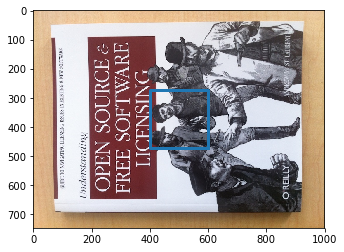

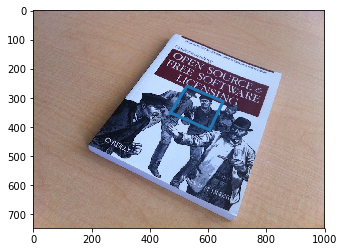

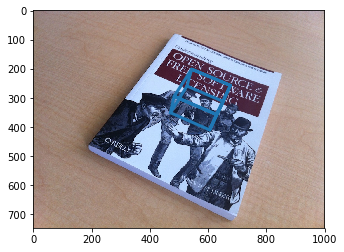

In [9]:
from PIL import Image	


im0 = np.array(Image.open('./Test-Images/book_frontal.JPG'))
im1 = np.array(Image.open('./Test-Images/book_perspective.JPG'))
# 2D projection of bottom square
plt.figure()
plt.imshow(im0)
plt.plot(box_cam1[0,:],box_cam1[1,:],linewidth=3)
# 2D projection transferred with H
plt.figure()
plt.imshow(im1)
plt.plot(box_trans[0,:],box_trans[1,:],linewidth=3)
# 3D cube
plt.figure()
plt.imshow(im1)
plt.plot(box_cam2[0,:],box_cam2[1,:],linewidth=3)
plt.show()

To reuse the measurements in future examples, we can save the camera matrices by using pickle.

In [10]:
import pickle

with open('ar_camera.pkl','w') as f:
    pickle.dump(K,f)
    pickle.dump(np.dot(linalg.inv(K),cam2.P),f)

### Augmented Reality

Augmented reality (AR) is a collective term for placing objects and information on top of image data. We will use two tools for this, PyGame and PyOpenGL. PyGame is a popular package for game development that easily handles display windows, input devices, events and much more. PyOpenGL is the Python binding to the OpenGL graphics programming interface.  
We want to place a 3D model in a scene using OpenGL.

In [11]:
from OpenGL.GL import *             # includes most functions we need
from OpenGL.GLU import *            # the OpenGL Utility library and contains some higher-level functionality (here: used to setup the camera projection)
import pygame, pygame.image         # 1. sets up the window and event controls / 2. e is used for loading image and creating OpenGL textures
from pygame.locals import *         # setting up the display area for OpenGL

pygame 2.0.3 (SDL 2.0.16, Python 2.7.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### From camera matrix to OpenGL format

OpenGL uses 4x4 matrices to represent transforms. The camera-scene transformations are separated in two matrices.  
1. GL_PROJECTION matrix  
    - handles the image formation properties
    - is the equivalent of our internal calibration matrix K
2. GL_MODELVIEW matrix  
    - handles the 3D transformation of the relation between the objects and the camera
    -  corresponds roughly to the R and t part of our camera matrix (one diference is that the coordinate system is assumed to be the camera center, so the GL_MODELVIEW matrix appends already the transformationm wich places the objects in front of the camera)

In the following, the calibration matrix K will be assumed as known so that the function can translate the camera properties to an OpenGL projection matrix

In [12]:
import math

height = 747
width = 1000

def set_projection_from_camera(K):
    
    """ Set view from a camera calibration matrix. """
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()

    fx = K[0,0]
    fy = K[1,1]
    
    fovy = 2*np.arctan(0.5*height/fy)*180/math.pi
    aspect = (width*fy)/(height*fx)

    # define the near and far clipping planes
    near = 0.1
    far = 100.0

    # set perspective
    gluPerspective(fovy,aspect,near,far)
    glViewport(0,0,width,height)

The function glMatrixMode() sets the working matrix to GL_PROJECTION. ThenglLoadIdentity() sets the matrix to the identity matrix, basically reseting any prior changes. We then calculate the vertical field of view in degrees with the help of the image height and the camera’s focal length as well as the aspect ratio. The funtion gluPerspective() to set the projection matrix and define the whole image to be the view port. The model view matrix should encode the relative rotation and translation that brings the object in front of the camera that typically looks like this
$$\begin{bmatrix}R & t\\
0 & 1
\end{bmatrix}$$

-> R is a rotation matrix with columns equal to the direction of the three coordinate axis
-> t is a translation vector

The following function shows how to take a 3 ⇥ 4 pin-hole camera matrix with the calibration removed (multiply P with $K^{-1}$) and create a model view.

In [13]:
def set_modelview_from_camera(Rt):
    """ Set the model view matrix from camera pose. """
    #switch to work on the GL_MODELVIEW matrix and reset it
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()

    # rotate teapot 90 deg around x-axis so that z-axis is up
    Rx = np.array([[1,0,0],[0,0,-1],[0,1,0]])

    # set rotation to best approximation
    R = Rt[:,:3]
    U,S,V = linalg.svd(R)   #make sure that its been a ratation matrix
    R = np.dot(U,V)         #the best rotation matrix approximation isgiven by R = UV^T
    R[0,:] = -R[0,:] # change sign of x-axis

    # set translation / flip the x-axis around 
    t = Rt[:,3]
    
    # setup 4*4 model view matrix
    M = np.eye(4)
    M[:3,:3] = np.dot(R,Rx)
    M[:3,3] = t
    
    # transpose and flatten to get column order
    M = M.T
    m = M.flatten()
    
    # replace model view with the new matrix
    glLoadMatrixf(m)

#### Placing virtual objects in the image

First, we need to add the image as a background. The best way to do this is by creating a quadrilateral (a quad) that fills the whole view. The easiest way to do this is to draw the quad with
the projection and model view matrices. Reset them so that the coordinates go from -1 to 1 in each dimension.

In [14]:
def draw_background(imname):
    """ Draw background image using a quad. """
    # load background image (should be .bmp) to OpenGL texture
    bg_image = pygame.image.load(imname).convert()
    bg_data = pygame.image.tostring(bg_image,"RGBX",1)

    # reset model and clear the color and depth buffer
    glMatrixMode(GL_MODELVIEW)                      
    glLoadIdentity()
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

    #bind the texture
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D,glGenTextures(1))
    glTexImage2D(GL_TEXTURE_2D,0,GL_RGBA,width,height,0,GL_RGBA,GL_UNSIGNED_BYTE,bg_data)
    glTexParameterf(GL_TEXTURE_2D,GL_TEXTURE_MAG_FILTER,GL_NEAREST)
    glTexParameterf(GL_TEXTURE_2D,GL_TEXTURE_MIN_FILTER,GL_NEAREST)

    # create quad to fill the whole window (corners at -1 and 1 in both dimensions)
    # Note that the coordinates in the texture image goes from 0 to 1
    glBegin(GL_QUADS)
    glTexCoord2f(0.0,0.0); glVertex3f(-1.0,-1.0,-1.0)
    glTexCoord2f(1.0,0.0); glVertex3f( 1.0,-1.0,-1.0)
    glTexCoord2f(1.0,1.0); glVertex3f( 1.0, 1.0,-1.0)
    glTexCoord2f(0.0,1.0); glVertex3f(-1.0, 1.0,-1.0)
    glEnd()

    # clear the texture, so it doesn't interfere with what we want to draw later
    glDeleteTextures(1)

In [15]:
from OpenGL.GLUT import *


# The following function will set up the color and properties to make a pretty red teapot
def draw_teapot(size):
    """ Draw a red teapot at the origin. """
  
    # glEnable is used to turn on OpenGL features
    glEnable(GL_LIGHTING) # enable lightning
    glEnable(GL_LIGHT0) # enable light
    glEnable(GL_DEPTH_TEST) # depth testing is turned on so that objects are rendered according to their depth
    glClear(GL_DEPTH_BUFFER_BIT) # the depth buffer is cleared

    # properties of the object are specified
    # draw red teapot
    glMaterialfv(GL_FRONT,GL_AMBIENT,[0,0,0,0])
    glMaterialfv(GL_FRONT,GL_DIFFUSE,[0.5,0.0,0.0,0.0])
    glMaterialfv(GL_FRONT,GL_SPECULAR,[0.7,0.6,0.6,0.0])
    glMaterialf(GL_FRONT,GL_SHININESS,0.25*128.0)
    glutSolidTeapot(size)       #generates a solid teapot model of relative size size

In [16]:
def load_and_draw_model(filename):
    """ Loads a model from an .obj file using objloader.py.
    Assumes there is a .mtl material file with the same name. """
    glEnable(GL_LIGHTING)
    glEnable(GL_LIGHT0)
    glEnable(GL_DEPTH_TEST)
    glClear(GL_DEPTH_BUFFER_BIT)

    # set model color
    glMaterialfv(GL_FRONT,GL_AMBIENT,[0,0,0,0])
    glMaterialfv(GL_FRONT,GL_DIFFUSE,[0.5,0.75,1.0,0.0])
    glMaterialf(GL_FRONT,GL_SHININESS,0.25*128.0)
    
    # load from a file
    import objloader
    obj = objloader.OBJ(filename,swapyz=True)
    glCallList(obj.gl_list)

#### Tying it all together

In [17]:
def setup():
    """ Setup window and pygame environment. """
    pygame.init()
    pygame.display.set_mode((width,height),OPENGL | DOUBLEBUF)
    pygame.display.set_caption('OpenGL AR demo')

# load camera data
#with open('ar_camera.pkl','r') as f:
 #   K = pickle.load(f)
  #  Rt = pickle.load(f)

#setup()
#draw_background('./Test-Images/book_perspective.bmp')
#set_projection_from_camera(K)
#set_modelview_from_camera(Rt)
#load_and_draw_model('./Examples/Toy_Plane/toyplane.obj')
#draw_teapot(0.02)

#while True:
#    event = pygame.event.poll()
#    if event.type in (QUIT,KEYDOWN):
#        break
#    pygame.display.flip()  # draws the object on the screen

## Multiple View Geometry

Multiple view geometry is the field studying the relationship between cameras and features when there are correspondences between many images that are taken from varying viewpoints.

### Epipolar Geometry

Epipolar geometry is a mathematical model that shows the relationships between images of the same object.

![Epipolar-Geometry](Pictures/epipolar-geometry.png)

#### The Fundamental Matrix F

F is a 3x3 matrix.

$$[x' y' 1] F  \begin{bmatrix}x\\
y\\
1
\end{bmatrix} = 0$$

For any (x,y) <-> (x',y') corresponce

How to get the epipolar lines from F?  
All epipolar lines intersects at the epipole (e.g. in the first image, the point ($x_{e}, y_{e}$) is on every epipolar line).
$$F  \begin{bmatrix}x_{e}\\
y_{e}\\
1
\end{bmatrix} = 0  = Fe_{1}$$
=> epipole is an eigenvector of F with the value 0

Fix (x,y) in $image_{1}$
$$\begin{bmatrix}x'\\y'\\1\end{bmatrix}^{T} F \begin{bmatrix}x\\y\\1\end{bmatrix} = 0 $$  

From this follows  

$$\begin{bmatrix}x'\\y'\\1\end{bmatrix}^{T} \begin{bmatrix}a\\b\\c\end{bmatrix} = 0 $$ 

That gives us

$$ax'+by'+c = 0$$ 

as the epipolar line in $image_{2}$



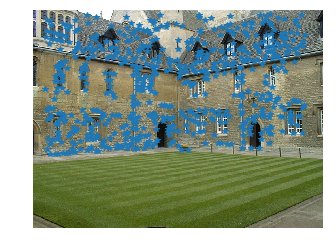

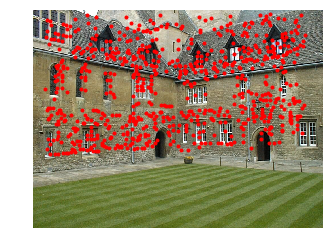

In [18]:


# load some images
im_1 = np.array(Image.open('./Examples/Merton_College_I/001.jpg'))
im_2 = np.array(Image.open('./Examples/Merton_College_I/002.jpg'))

# load 2D points for each view to a list
points2D = [np.loadtxt('./Examples/Merton_College_I/2D/00'+str(i+1)+'.corners').T for i in range(3)]

# load 3D points
points3D = np.loadtxt('./Examples/Merton_College_I/3D/p3d').T

# load correspondences
corr = np.genfromtxt('./Examples/Merton_College_I/2D/nview-corners',dtype='int')

# load camers to a list of Camera objects
P = [Camera(np.loadtxt('./Examples/Merton_College_I/2D/00'+str(i+1)+'.P')) for i in range(3)]

# make 3D points homogeneous and project
X = np.vstack( (points3D, np.ones(points3D.shape[1])))
x = P[0].project(X)

# plotting the points in view 1
plt.figure()
plt.imshow(im_1)
plt.plot(points2D[0][0], points2D[0][1],'*')
plt.axis('off')

plt.figure()
plt.imshow(im_2)
plt.plot(x[0],x[1],'r.')
plt.axis('off')

plt.show()

#### Plotting 3D data with Matplotlib

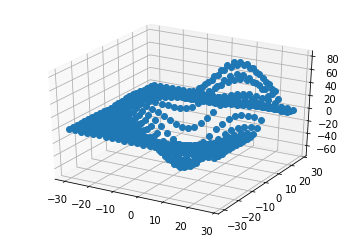

In [19]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
# Making a plot in 3D is done by adding the projection="3d" keyword
ax = fig.gca(projection="3d")

# generate 3D sample data
X,Y,Z = axes3d.get_test_data(0.25)
# plot the points in 3D
ax.plot(X.flatten(),Y.flatten(),Z.flatten(),'o')

plt.show()

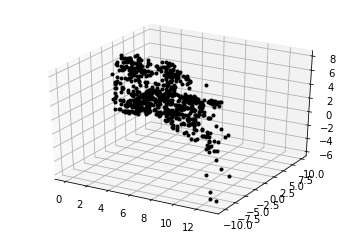

In [20]:
# plotting 3D points from example
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(points3D[0],points3D[1],points3D[2],'k.')

plt.show()

### Computing F - The eight point algorithm

The eight point algorithm is an algorithm for computing the fundamental matrix from point correspondences.

The epipolar constraint can be written as a linear system like:

![Epipolar-Geometry](Pictures/Epipolar-constraints.png)

where f contains the elements of F. The first matrix consists of corresponding pairs and there are n point correspondences in total. F has nine elements but since the scale is arbitrary, only eight equations are needed. So, eight point correspondences are needed to compute F

### The epipole and epipolar lines

The epipole satisfies Fe1 = 0 and can be computed from the null space of F.

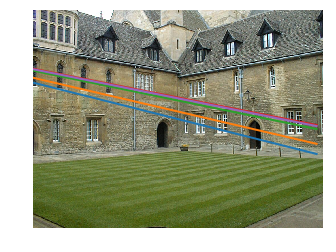

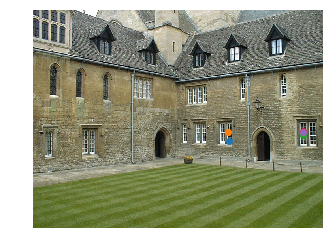

In [21]:
from PCV.geometry import sfm

# index for points in first two views
'''the missing values in the correspondence list corr are -1 so picking indices
greater or equal to zero gives the points visible in each view '''
ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = np.vstack( (x1,np.ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = np.vstack( (x2,np.ones(x2.shape[1])) )

# compute F
F = sfm.compute_fundamental(x1,x2)
# compute the epipole
e = sfm.compute_epipole(F)
# plotting
plt.figure()

plt.imshow(im_1)
# plot each line individually, this gives nice colors
for i in range(5):
    sfm.plot_epipolar_line(im1,F,x2[:,i],e,False)
plt.axis('off')

plt.figure()
plt.imshow(im_2)
# plot each point individually, this gives same colors as the lines
for i in range(5):
    plt.plot(x2[0,i],x2[1,i],'o')
plt.axis('off')
plt.show()

### Computing with Cameras and 3D Stucture

The following code will triangulate the points in correspondence from the first two views and print out the coordinates of the first two points before plotting the values. The estimated points are shown with black circles and the true points with red dots.


[[ 1.03743725  1.56125273  1.40720017]
 [-0.57574987 -0.55504127 -0.46523952]
 [ 3.44173797  3.44249282  7.53176488]
 [ 1.          1.          1.        ]]
[[ 1.0378863   1.5606923   1.4071907 ]
 [-0.54627892 -0.5211711  -0.46371818]
 [ 3.4601538   3.4636809   7.5323397 ]
 [ 1.          1.          1.        ]]


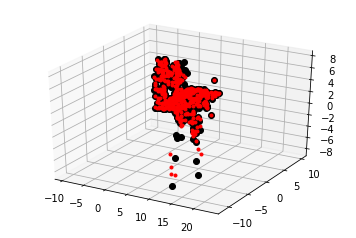

In [22]:
# index for points in first two views
ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = np.vstack( (x1,np.ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = np.vstack( (x2,np.ones(x2.shape[1])) )
Xtrue = points3D[:,ndx]
Xtrue = np.vstack( (Xtrue,np.ones(Xtrue.shape[1])) )

# check first 3 points
Xest = sfm.triangulate(x1,x2,P[0].P,P[1].P)
print Xest[:,:3]
print Xtrue[:,:3]

# plotting
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(Xest[0],Xest[1],Xest[2],'ko')
ax.plot(Xtrue[0],Xtrue[1],Xtrue[2],'r.')
plt.axis('equal')
plt.show()

### Computing the camera matrix from 3D points

The camera matrix (P) can be computed. We have to know 3D points and their image projections. Futheremore, we have to use a direct linear transform approach.  
The estimation of camera matrix will than be detected with SVD. 
The first 12 values of the last eigenvector are the elements of the camera matrix and are returned after a reshaping operation (cf. compute_P(x,X) in sfm.py).

[[ 1.06520794e+00 -5.23431275e+01  2.06902749e+01  5.08729305e+02]
 [-5.05773115e+01 -1.33243276e+01 -1.47388537e+01  4.79178838e+02]
 [ 3.05121915e-03 -3.19264684e-02 -3.43703738e-02  1.00000000e+00]]
[[ 1.06774679e+00 -5.23448212e+01  2.06926980e+01  5.08764487e+02]
 [-5.05834364e+01 -1.33201976e+01 -1.47406641e+01  4.79228998e+02]
 [ 3.06792659e-03 -3.19008054e-02 -3.43665129e-02  1.00000000e+00]]


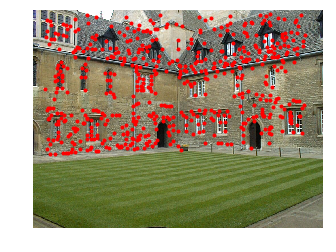

In [23]:
corr = corr[:,0] # view 1
ndx3D = np.where(corr>=0)[0] # missing values are -1
ndx2D = corr[ndx3D]

# select visible points and make homogeneous
x = points2D[0][:,ndx2D] # view 1
x = np.vstack( (x,np.ones(x.shape[1])) )
X = points3D[:,ndx3D]
X = np.vstack( (X,np.ones(X.shape[1])) )

# estimate P
Pest = Camera(sfm.compute_P(x,X))

# compare!
print Pest.P / Pest.P[2,3]
print P[0].P / P[0].P[2,3]
xest = Pest.project(X)

# plotting
plt.figure()
plt.imshow(im_1)
#plt.plot(x[0],x[1],'b')
plt.plot(xest[0],xest[1],'r.')
plt.axis('off')
plt.show()

The top is the estimated camera matrix and below the one computed by the creators
of the data set. So, we can see that they are actually identical. The result is plotted with the estimated camera projection in red.

### Computing the camera matrix from a fundamental matrix 

If it is a two view scenario, the camera matrix can be recovered from the fundamental matrix (F). Assuming the first camera matrix is normalized to $P_{1} = [I | 0]$, the problem is to find the second camera matrix $P_{2}$.  
There are two cases:  
1. The uncalibrated case
2. The calibrated case

#### The uncalibrated case - projective reconstruction

In this case, if the camera pair is used to reconstruct 3D points, the reconstruction do not take care of angles and distances. So, a simple representation is 

$$P_{2} = [S_{e}F|e] ,$$
where e is the left epipole, $e^{T}F = 0$ and $S_{e}$ a skew matrix.  
A triangulation with this matrix will most likely give distortions, for example in the form of skewed reconstructions.

#### The calibrated case - metric reconstrunction

With known calibration (K) the reconstruction will be metric and preserve properties of Euclidean space (except for a global scale parameter). 
So, with K we can take use of its inverse $K^{-1}$ so that the camera equation looks like:
$$x_{K} = K^{-1}K[R|t]X = [R|t]X$$

The essential matrix (usually denoted E) the fundamental matrix for calibration normalized coordinates.
 

### Multiple View Reconstruction

Assuming the camera has been calibrated, the steps are as follows:
1. Detect feature points and match them between the two images.
2. Compute the fundamental matrix from the matches.
3. Compute the camera matrices from the fundamental matrix.
4. Triangulate the 3D points.

#### Robust fundamental matrix estimation

We will use RANSAC combined with the eight point algorithm. The eight point algorithm does not work if all points are on a plane. 

### 3D reconstruction example


1. The calibration (K) is known at the beginning.
2. Pick out the points that belong to matches.
3. Normalize them with $K^{-1}$.
4. Run the RANSAC estimation with the normalized eight point algorithm. 

Interim result = essential matrix

5. Make sure to keep the index of the inliers.
6. Compute the four possible solutions of the second camera matrix from the essential matrix.
7. Pick the camera matrix with the most scene points in front of both cameras after triangulation.  
7.1. Loop through the four solutions and each time triangulate the 3D points corresponding to the inliers.  
The sign of the depth is given by the third value of each image point after projecting the triangulated X back to the images.  
7.2. keep the index with the most positive depths and also store a boolean for each point in the best solution so that we can pick only the ones that actually are in front.
8. Once we have the right solution, we triangulate the inliers and keep the points in front of the cameras.

The images of the example are of the famous Alcatraz prison

In [24]:
sift_CV2 = cv2.xfeatures2d.SIFT_create()

# load image
img1 = cv2.imread('./Examples/Alcatraz/alcatraz1.JPG')
img2 = cv2.imread('./Examples/Alcatraz/alcatraz2.JPG')
# find keypoints and descriptors with SIFT
kp1, des1 = sift_CV2.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift_CV2.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)


# find point matches
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's SIFT matching ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

# Constrain matches to fit homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
#mask = mask.ravel()

# load camera data
#with open('ar_camera.pkl','r') as f:
#    K = pickle.load(f)
Rt = np.dot(linalg.inv(K),cam2.P)
setup()
draw_background('./Examples/Alcatraz/alcatraz1.JPG')
set_projection_from_camera(K)
set_modelview_from_camera(Rt)
#load_and_draw_model('./Examples/Toy_Plane/toyplane.obj')
#draw_teapot(0.02)

while True:
    event = pygame.event.poll()
    if event.type in (QUIT,KEYDOWN):
        break
    pygame.display.flip()  # draws the object on the screen